In [25]:
import numpy as np
import scipy
import matplotlib.pyplot as plt 
from numpy.linalg import eig
import matplotlib.animation as animation
from IPython.display import clear_output
import subprocess
import random
from datetime import datetime

location_of_getXY = r'C:\Users\jmcc0\Desktop\FYP\Frank code\getXY.exe'
dir_of_getXY = r'C:\Users\jmcc0\Desktop\FYP\Frank code'
location_of_getGap = r'C:\Users\jmcc0\Desktop\FYP\QWI\getGap.exe'
dir_of_getGap = r'C:\Users\jmcc0\Desktop\FYP\QWI'

# ! ! !  DO NOT FORGET TO SET DIRECTORY FOR SAVING FILES AT END OF SCRIPT ! ! ! 

def getXY(BG_in):
    # Define the command to run the compiled C++ executable
    executable_path = location_of_getXY
    run_command = [executable_path]

    # Run the compiled C++ code
    process = subprocess.Popen(run_command, stdin=subprocess.PIPE, stdout=subprocess.PIPE, cwd=dir_of_getXY)

    # Provide input to the C++ program
    BG = BG_in
    process.stdin.write(str(BG).encode())
    process.stdin.close()

    # Read the output from the C++ program
    output = process.stdout.read().decode().strip()
    x_str, y_str = output.split('\t')
    x = float(x_str.split('=')[1])
    y = float(y_str.split('=')[1])
    # Now you have the x and y values from the C++ code
    print("x =", x)
    print("y =", y)
    
    return x, y

def getGap(layers):
    with open('input.txt', 'w') as f:
        f.write(str(int(len(layers))) + "\n")
        for layer in layers:
            f.write(str(layer.material.name) + " " + str(layer.thickness) + "\n")
    with open('materials.txt', 'w') as f:
        for material in materials:
            f.write(material.name + " " + str(material.affinity) + " " + str(material.band_gap) + " " + str(material.e_eff_mass) + " " + str(material.lh_eff_mass) + " " + str(material.hh_eff_mass) + " " + str(material.refractive) + "\n")
        for material in alloys:
            f.write(material.name + " " + str(material.affinity) + " " + str(material.band_gap) + " " + str(material.e_eff_mass) + " " + str(material.lh_eff_mass) + " " + str(material.hh_eff_mass) + " " + str(material.refractive) + "\n")
    
    executable_path = location_of_getGap
    run_command = [executable_path]
    process = subprocess.Popen(run_command, stdin=subprocess.PIPE, stdout=subprocess.PIPE, cwd=dir_of_getGap)
    
    output = process.stdout.read().decode().strip()
    lines = output.split('\n')

    # Initialize variables to store the values
    energy_e = None
    energy_lh = None
    energy_hh = None

    # Process each line
    for line in lines:
        parts = line.split(':')
        if len(parts) == 2:  # Ensure the line has a label and a value
            label = int(parts[0])
            value = float(parts[1])
            if label == 0:
                energy_e = value
            elif label == 1:
                energy_lh = value
            elif label == 2:
                energy_hh = value
    
    return max(1240/abs(energy_e-energy_lh), 1240/abs(energy_e-energy_hh))

# voigt function details
num_discrete = 2048
func_x = np.zeros(num_discrete)
Gauss_y = np.zeros(num_discrete)
Lorentz_y = np.zeros(num_discrete)
x_0 = num_discrete/2
gamma = 50
sigma = gamma
PLOT_LIMIT=[]

def pad_func_zeros(func):
    func_new = np.zeros(2*len(func))
    j = 0
    for i in range(int(0.25*len(func_new)), int(0.75*len(func_new))):
        func_new[i] = func[j]
        j+=1
    return func_new # twice in length

def pad_func_linear(func):
    func_new = np.zeros(2*len(func))
    j = 0
    del_f = np.abs(func[1]-func[2])
    for i in range(0, int(0.25*len(func_new))):
        func_new[i] = func[0]-0.5*(func[len(func)-1]-func[0]) + i*del_f
    for i in range(int(0.25*len(func_new)), int(0.75*len(func_new))):
        func_new[i] = func[j]
        j+=1
    w=j-1
    j=1
    for i in range(int(0.75*len(func_new)), len(func_new)):
        func_new[i] = func[w] + j*del_f
        j+=1
    return func_new # twice in length

def pad_E(f):
    del_f = np.max(f)/(num_discrete-1)
    func_new = np.zeros(2*len(f))
    j = 0
    for i in range(len(func_new)):
        func_new[i] = del_f*i
    return func_new # twice in length

def convolve(f, g): # PAD ARRAYS BEFORE USE FRO ABSORPTION
    FFT_f = np.fft.fft(f)
    FFT_g = np.fft.fft(g)
    FG = FFT_f * FFT_g
    result = np.fft.ifft(FG)
    return np.real(result)

# plotting
PLOT_LIMIT = []#400,800]
Y_LIMIT = [] # leave blank for auto
ERROR_BARS = False
PLOT_FITTED = False
split_ = ","
LABEL_FONT_SIZE = 13
TICK_FONT_SIZE = 11
LINE_WIDTH = 0.5
MARKER_SIZE = 1
LEGEND = True
label_x = ""
label_y = ""
plot_title = ""
aspect_ratio = [9,9]

colours = [ 'black', 'dimgrey', 'lightslategrey', 'lightsteelblue', 'silver', 'cadetblue', 'darkcyan', 'darkslategray', 'seagreen', 'mediumseagreen', 'darkolivegreen', 'olivedrab', 'olive', 'yellowgreen', 'green', 'springgreen', 'mediumspringgreen', 'turquoise', 'lightseagreen']

def plot_graph(x, y): #create a single plot
    labels = []
    plt.figure()
    plt.rcParams["figure.figsize"] = (aspect_ratio[0],aspect_ratio[1])
    fig, ax = plt.subplots()
    plt.title(plot_title)
    plt.xlabel(label_x, fontsize=LABEL_FONT_SIZE)
    plt.ylabel(label_y,  fontsize=LABEL_FONT_SIZE)
    plt.xticks(fontsize = TICK_FONT_SIZE)
    plt.yticks(fontsize = TICK_FONT_SIZE)
    if(bool(Y_LIMIT) == True):
        plt.ylim(Y_LIMIT)
    if(bool(PLOT_LIMIT) == True):
        plt.xlim(PLOT_LIMIT)
    
    right_side = ax.spines["right"]
    top_side = ax.spines["top"]
    right_side.set_visible(False)
    top_side.set_visible(False)
    plt.plot(x, y, linewidth = LINE_WIDTH, color = 'dimgrey', marker = 's', markersize = MARKER_SIZE, markerfacecolor='dimgrey')
    plt.grid(True, alpha=0.2)
    #labels = np.array(labels)
    #plt.savefig(f'{file}_figure.png', dpi = 1000, bbox_inches='tight')
    plt.show()

def plot_graphs(x, y): #create a single plot
    labels = []
    plt.figure()
    plt.rcParams["figure.figsize"] = (6,6)
    fig, ax = plt.subplots()
    plt.title(plot_title)
    plt.xlabel(label_x, fontsize=LABEL_FONT_SIZE)
    plt.ylabel(label_y,  fontsize=LABEL_FONT_SIZE)
    #ax.xaxis.set_minor_locator(AutoMinorLocator())
    #plt.xticks(fontsize = TICK_FONT_SIZE)
    #plt.yticks(fontsize = TICK_FONT_SIZE)
    if(bool(Y_LIMIT) == True):
        plt.ylim(Y_LIMIT)
    if(bool(PLOT_LIMIT) == True):
        plt.xlim(PLOT_LIMIT)
    
    right_side = ax.spines["right"]
    top_side = ax.spines["top"]
    right_side.set_visible(False)
    top_side.set_visible(False)
    i=0
    for ys in y:
        if i < len(colours):
            plt.plot(x, ys, linewidth = LINE_WIDTH, marker = 's', markersize = MARKER_SIZE, color = colours[i])
        else:
            plt.plot(x, ys, linewidth = LINE_WIDTH, marker = 's', markersize = MARKER_SIZE)
        i+=1
    plt.grid(True, alpha=0.2)
    if(LEGEND==True):
        plt.legend(legend)
    #labels = np.array(labels)
    #plt.savefig(f'{file}_figure.png', dpi = 1000, bbox_inches='tight')
    plt.show()
    
def plot_graphs_distinct(x, y): #create a single plot
    labels = []
    plt.figure()
    plt.rcParams["figure.figsize"] = (6,6)
    fig, ax = plt.subplots()
    plt.title(plot_title)
    plt.xlabel(label_x, fontsize=LABEL_FONT_SIZE)
    plt.ylabel(label_y,  fontsize=LABEL_FONT_SIZE)
    #ax.xaxis.set_minor_locator(AutoMinorLocator())
    #plt.xticks(fontsize = TICK_FONT_SIZE)
    #plt.yticks(fontsize = TICK_FONT_SIZE)
    if(bool(Y_LIMIT) == True):
        plt.ylim(Y_LIMIT)
    if(bool(PLOT_LIMIT) == True):
        plt.xlim(PLOT_LIMIT)
    
    right_side = ax.spines["right"]
    top_side = ax.spines["top"]
    right_side.set_visible(False)
    top_side.set_visible(False)
    i=0
    for ys in y:
        if i < len(colours):
            plt.plot(x[i], ys, linewidth = LINE_WIDTH, marker = 's', markersize = MARKER_SIZE, color = colours[i])
        else:
            plt.plot(x[i], ys, linewidth = LINE_WIDTH, marker = 's', markersize = MARKER_SIZE)
        i+=1
    plt.grid(True, alpha=0.2)
    if(LEGEND==True):
        plt.legend(legend)
    #labels = np.array(labels)
    #plt.savefig(f'{file}_figure.png', dpi = 1000, bbox_inches='tight')
    plt.show()

def make_array(y, number_steps):
    p = np.zeros(number_steps)
    for nr in range(0, number_steps):
        p[nr] = y
    return p

def read_in(file_path):
    x_data_ = []
    y_data_ = []
    try:
        with open(file_path, 'r') as file:
            for line in file:
                # Split the line into x and y values
                x_val, y_val = map(float, line.strip().split())
                x_data_.append(x_val)
                y_data_.append(y_val)
    except FileNotFoundError:
        print("File not found:", file_path)

    # Convert lists to numpy arrays
    x_array_ = np.array(x_data_)
    y_array_ = np.array(y_data_)
    
    #plot_graph(x_array_, y_array_)
    
    return x_array_, y_array_

In [26]:
def write_simulation_parameters(inter_mixing_params, num_electric_fields, max_electric_field):
    with open('simulation_parameters.txt', 'w') as f:
        f.write(f"{inter_mixing_params[0]} {inter_mixing_params[1]}\n")
        f.write(f"{num_electric_fields}\n")
        f.write(f"{max_electric_field}\n")

class Layer:
    def __init__(self, material, thickness): # thickness in [A]
        self.material = material
        self.thickness = thickness

class Material:
    def __init__(self, name, affinity, band_gap, e_eff_mass, lh_eff_mass, hh_eff_mass, refractive):
        self.affinity = affinity
        self.band_gap = band_gap
        self.e_eff_mass = e_eff_mass
        self.lh_eff_mass = lh_eff_mass
        self.hh_eff_mass = hh_eff_mass
        self.name = name
        self.refractive = refractive
        
    def getEffectiveMass(self, p):
        if p == 0:
            return self.e_eff_mass
        if p == 1:
            return self.lh_eff_mass
        if p == 2:
            return self.hh_eff_mass
        
    def getBandgap(self):
        return self.band_gap
    
    def getRefractive(self):
        return self.refractive
    
# Example Materials // BG = Bandgap, EF = Effective Electron Affinity for placing bands [REF: Takuya IEEE Quantum Electronics Vol 30, NO.2]
# Decleration: Material(EF, BG, e_eff_mass, lh_eff_mass, hh_eff_mass, refractive index) 
GaAs = Material("GaAs", 0.111, 1.42, 0.067, 0.08, 0.50, 3.9476)
GaP = Material("GaP", -0.388, 2.74, 0.25, 0.14, 0.67, 3.3798)
InP = Material("InP", 0.0, 1.35, 0.077, 0.12, 0.6, 3.3688)
InAs = Material("InAs", 0.441, 0.354, 0.023, 0.025, 0.40, 3.714)
AlAs = Material("AlAs", -0.4245, 2.95, 0.15, 0.16, 0.79, 2.9940) 
materials = [GaAs, GaP, InP, InAs, AlAs]
# Simulation setup :: InGaAlAs
alloys = []

def BG_InGaAlAs(x, y):
    return 0.36 + 2.093*y + 0.629*x + 0.577*y*y + 0.436*x*x + 1.013*x*y - 2.0*x*y*(1-x-y); # [eV]
def EF_InGaAlAs(x, y): # Effective electron finity for placing conduction bands InGaAlAs
    return 0.5766 - 0.3439*BG_InGaAlAs(x, y) # [eV] 
def effMass_InGaAlAs(x, y, particle):
    return InAs.getEffectiveMass(particle)*(1-x-y) + GaAs.getEffectiveMass(particle)*(x) + AlAs.getEffectiveMass(particle)*(y);
def refractive_InGaAlAs(x, y):
    E_g = BG_InGaAlAs(x,y);
    x=(E_g-0.75)/0.72;
    w = 1240/E_g
    if (x>1.0): x = 1
    A = 9.689 - 1.012*x;
    B = 1.590 - 0.376*x;
    C = 1102.4 - 702.0*x + 330.4*x*x;
    if (C+100 < w):
        X = w*w-C*C
    else: 
        X = (200*w+10000)
    return np.sqrt(A + B*w*w/X);
def InGaAlAs_material(bandgap): # in nm
    bandgap = 1240/bandgap
    x, y = getXY(bandgap)
    temp = Material("In{}Ga{}Al{}As".format(1-x-y,x,y), EF_InGaAlAs(x, y), BG_InGaAlAs(x, y), effMass_InGaAlAs(x, y, 0), effMass_InGaAlAs(x, y, 1), effMass_InGaAlAs(x, y, 2), refractive_InGaAlAs(x,y))
    print(BG_InGaAlAs(x, y))
    alloys.append(temp)
    return temp

def findAlloys(layers, target):
    sigma = 2500
    sigma0 = 500
    sigma_prev = sigma0
    i = 0
    while i <= 12:
        alloys=[]
        for layer in layers:
            if layer.material.name != 'InP':  # Exclude InP layers from modification
                old_bandgap = 1240/layer.material.band_gap
                new_bandgap = old_bandgap + (target - getGap(layers))  # Adjust each layer's bandgap individually
                layer.material = InGaAlAs_material(new_bandgap)
        with open('input.txt', 'w') as f:
            f.write(str(int(len(layers))) + "\n")
            for layer in layers:
                f.write(str(layer.material.name) + " " + str(layer.thickness) + "\n")

        with open('materials.txt', 'w') as f:
            for material in materials:
                f.write(material.name + " " + str(material.affinity) + " " + str(material.band_gap) + " " + str(material.e_eff_mass) + " " + str(material.lh_eff_mass) + " " + str(material.hh_eff_mass) + " " + str(material.refractive) + "\n")
            for material in alloys:
                f.write(material.name + " " + str(material.affinity) + " " + str(material.band_gap) + " " + str(material.e_eff_mass) + " " + str(material.lh_eff_mass) + " " + str(material.hh_eff_mass) + " " + str(material.refractive) + "\n")
        clear_output()
        testGap = getGap(layers)
        temp = sigma
        print(testGap)
        if testGap > target + 1:
            sigma = (sigma0 + sigma) / 2.0
            sigma_prev = temp
        elif testGap < target - 1:
            sigma0 = sigma
            sigma = (sigma_prev + sigma) / 2.0
        else:
            break
        i += 1
        
    if(i>=12): success = False
    else: success = True
    print("out: " + str(testGap))
    return layers, success

print(BG_InGaAlAs(0.1831, 0.283))

1.12547783092


In [27]:
def parse_input_file(input_file):
    layers = []
    with open(input_file, 'r') as f:
        num_layers = int(f.readline().strip())
        for _ in range(num_layers):
            layer_info = f.readline().strip().split()
            material = layer_info[0]
            thickness = float(layer_info[1])
            layers.append((material, thickness))
    return layers

def parse_materials_file(materials_file):
    materials = {}
    with open(materials_file, 'r') as f:
        for line in f:
            material_info = line.strip().split()
            material = material_info[0]
            properties = [float(prop) for prop in material_info[1:]]
            materials[material] = properties
    return materials

def parse_simulation_parameters_file(simulation_params_file):
    with open(simulation_params_file, 'r') as f:
        qwi_target_shift = float(f.readline().split(" ")[1])
        num_electric_fields = int(f.readline().strip())
        max_applied_efield = float(f.readline().strip())
    return qwi_target_shift, num_electric_fields, max_applied_efield

def write_data_to_file(filename, data_dict):
    with open(filename, 'w') as f:
        for key, value in data_dict.items():
            f.write(f"{key}:\n")
            if isinstance(value, list):
                for item in value:
                    f.write(f"{item}\n")
            elif isinstance(value, dict):
                for subkey, subvalue in value.items():
                    f.write(f"{subkey}: {subvalue}\n")
            else:
                f.write(f"{value}\n")

def read_data_from_file(filename):
    data_dict = {}
    with open(filename, 'r') as f:
        lines = f.readlines()
        i = 0
        while i < len(lines):
            key = lines[i].strip(":\n")
            i += 1
            if key in ["Layers", "Materials"]:
                data_dict[key] = {}
                while i < len(lines) and lines[i] != "\n":
                    line = lines[i].strip("\n")
                    if line and ":" in line:
                        subkey, subvalue = line.split(": ", 1)  # Limit split to 1 occurrence
                        data_dict[key][subkey] = subvalue
                    i += 1
            else:
                if i < len(lines):
                    value = lines[i].strip("\n")
                    data_dict[key] = value
                    i += 1
    return data_dict

In [28]:

# --------------------------- TEST SCRIPT -------------------------------

# Example Materials // BG = Bandgap, EF = Effective Electron Affinity for placing bands [REF: Takuya IEEE Quantum Electronics Vol 30, NO.2]
# Decleration: Material(EF, BG, e_eff_mass, lh_eff_mass, hh_eff_mass, refractive index) 
GaAs = Material("GaAs", 0.111, 1.42, 0.067, 0.08, 0.50, 3.9476)
GaP = Material("GaP", -0.388, 2.74, 0.25, 0.14, 0.67, 3.3798)
InP = Material("InP", 0.0, 1.35, 0.077, 0.12, 0.6, 3.3688)
InAs = Material("InAs", 0.441, 0.354, 0.023, 0.025, 0.40, 3.714)
AlAs = Material("AlAs", -0.4245, 2.95, 0.15, 0.16, 0.79, 2.9940) 
materials = [GaAs, GaP, InP, InAs, AlAs]
# Simulation setup :: InGaAlAs
alloys = []

layer1 = Layer(InAs, 50)
InP_layer = Layer(InP, 100)
layer5 = Layer(GaAs, 50)
layer7 = Layer(AlAs, 50)

layer2 = Layer(InGaAlAs_material(1549.81), 30)
layer3 = Layer(InGaAlAs_material(1549.81), 100)
layer5 = Layer(InGaAlAs_material(1700), 75)
layer6 = Layer(InGaAlAs_material(1200), 30)
layer4 = Layer(InGaAlAs_material(1350), 40)
InP_layer2 = Layer(InGaAlAs_material(1150), 100)
layer3 = Layer(InGaAlAs_material(1400.81), 30)
InP_layer = Layer(InGaAlAs_material(1239.85), 100)

layers = [InP_layer2, layer3,  InP_layer2]

# GOOD DESIGN 
layers = [InP_layer2, layer2, layer6, layer5, layer4, InP_layer2]

print("Initial Bandgap: " + str(getGap(layers)))

with open('input.txt', 'w') as f:
    f.write(str(int(len(layers))) + "\n")
    for layer in layers:
        f.write(str(layer.material.name) + " " + str(layer.thickness) + "\n")

with open('materials.txt', 'w') as f:
    for material in materials:
        f.write(material.name + " " + str(material.affinity) + " " + str(material.band_gap) + " " + str(material.e_eff_mass) + " " + str(material.lh_eff_mass) + " " + str(material.hh_eff_mass) + " " + str(material.refractive) + "\n")
    for material in alloys:
        f.write(material.name + " " + str(material.affinity) + " " + str(material.band_gap) + " " + str(material.e_eff_mass) + " " + str(material.lh_eff_mass) + " " + str(material.hh_eff_mass) + " " + str(material.refractive) + "\n")

num_electric_fields = 10 # simulation cxx - not python
max_electric_field = 10
wavelength_shift = 0 #max_shift/num_runs + j*max_shift/num_runs

QWI_params = ["True", wavelength_shift]
write_simulation_parameters(QWI_params, num_electric_fields, max_electric_field)
#subprocess.run(['simulation_multithread.exe'])
layers, check = findAlloys(layers, 1500)

1500.3859863948871
out: 1500.3859863948871


1500.0


<Figure size 600x600 with 0 Axes>

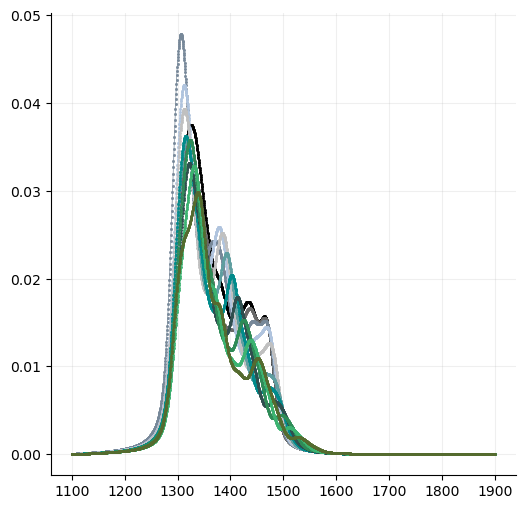

index_1450: 896
index_1650: 1279
1023
0.0 at 1748.3599999999842
0.1252167439607601 at 1748.3599999999842
0.35206769554960804 at 1748.3599999999842
0.7451566728621397 at 1759.6699999999805
0.9186893064403805 at 1767.079999999978
1.064040226839818 at 1785.4099999999721
1.470687512905117 at 1802.1799999999666
1.8757539343769634 at 1518.18
2.060816091877356 at 1527.96
2.1465294463308813 at 1540.08
[0.         0.10520582 0.30835415 0.71018633 0.90766011 0.93741602
 1.00818441 0.7934968  0.15879178 0.19686434 0.        ]


0.2234631635483073
1.0081844089663177


<Figure size 600x600 with 0 Axes>

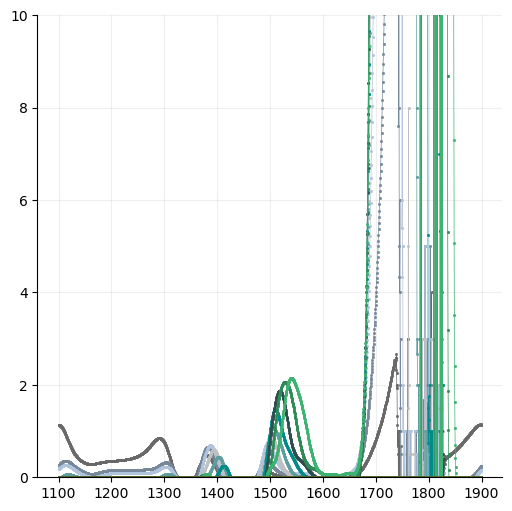

Layers: [('In0.529914Ga0.345879Al0.124207As', 100.0), ('In0.529417Ga0.316369Al0.154214As', 22.498946430948187), ('In0.5319670000000012Ga0.468033Al-1.11468e-15As', 31.640157626040466), ('In0.5313709Ga0.432553Al0.0360761As', 28.483392650177958), ('In0.529914Ga0.345879Al0.124207As', 100.0)]
Materials: {'GaAs': [0.111, 1.42, 0.067, 0.08, 0.5, 3.9476], 'GaP': [-0.388, 2.74, 0.25, 0.14, 0.67, 3.3798], 'InP': [0.0, 1.35, 0.077, 0.12, 0.6, 3.3688], 'InAs': [0.441, 0.354, 0.023, 0.025, 0.4, 3.714], 'AlAs': [-0.4245, 2.95, 0.15, 0.16, 0.79, 2.994], 'In0.5258860000000001Ga0.106431Al0.367683As': [0.13711909629132013, 1.277932258530619, 0.074378705, 0.08049091, 0.55403947, 3.5248520927437155], 'In0.52985Ga0.342124Al0.128026As': [0.2665398915236515, 0.9015996175526273, 0.054312758, 0.06110033, 0.48414254, 3.53234112235753], 'In0.529652Ga0.330385Al0.139963As': [0.2610689902912766, 0.9175080247418534, 0.055312241, 0.06206618, 0.4876240700000001, 3.5308524941995123], 'In0.5243308Ga0.0139502Al0.461719As

In [ ]:
num_runs_QWI = 8
max_shift_QWI = 50 #nm
num_electric_fields = 11 # simulation cxx - not python
max_electric_field = 10

wells=0
for iter in range(100000):
    alloys=[]
    clear_output()
    layer1 = Layer(InGaAlAs_material(random.uniform(900,1650)), random.uniform(20,60))
    layer3 = Layer(InGaAlAs_material(random.uniform(900,1650)), random.uniform(20,60))
    layer2 = Layer(InGaAlAs_material(random.uniform(1000,2000)), random.uniform(20,60))
    InP_layer = Layer(InGaAlAs_material(random.uniform(800,1350)), 100)
    layers = [InP_layer, layer1, layer2, layer3, InP_layer]
    with open('input.txt', 'w') as f:
        f.write(str(int(len(layers))) + "\n")
        for layer in layers:
            f.write(str(layer.material.name) + " " + str(layer.thickness) + "\n")
    with open('materials.txt', 'w') as f:
        for material in materials:
            f.write(material.name + " " + str(material.affinity) + " " + str(material.band_gap) + " " + str(material.e_eff_mass) + " " + str(material.lh_eff_mass) + " " + str(material.hh_eff_mass) + " " + str(material.refractive) + "\n")
        for material in alloys:
            f.write(material.name + " " + str(material.affinity) + " " + str(material.band_gap) + " " + str(material.e_eff_mass) + " " + str(material.lh_eff_mass) + " " + str(material.hh_eff_mass) + " " + str(material.refractive) + "\n")

    print("Initial Bandgap: " + str(getGap(layers)))
    layers, check = findAlloys(layers, 1500)
    
    calc1=layers[0].material.affinity
    calc2=max(layer.material.affinity for layer in layers[1:4])
    print(calc2-calc1)
    if(calc2-calc1 < 0.05):
        check = False

    if(check == True):
        with open('input.txt', 'w') as f:
            f.write(str(int(len(layers))) + "\n")
            for layer in layers:
                f.write(str(layer.material.name) + " " + str(layer.thickness) + "\n")

        with open('materials.txt', 'w') as f:
            for material in materials:
                f.write(material.name + " " + str(material.affinity) + " " + str(material.band_gap) + " " + str(material.e_eff_mass) + " " + str(material.lh_eff_mass) + " " + str(material.hh_eff_mass) + " " + str(material.refractive) + "\n")
            for material in alloys:
                f.write(material.name + " " + str(material.affinity) + " " + str(material.band_gap) + " " + str(material.e_eff_mass) + " " + str(material.lh_eff_mass) + " " + str(material.hh_eff_mass) + " " + str(material.refractive) + "\n")
        wells+=1
        for k in range(num_runs_QWI):
            print("Wells:" + str(wells))
            print("iter:" + str(iter))
            wavelength_shift = k*max_shift_QWI/num_runs_QWI #max_shift/num_runs + j*max_shift/num_runs

            QWI_params = ["True", wavelength_shift]
            # FOM_DATA_QWI_x.append(wavelength_shift)
            write_simulation_parameters(QWI_params, num_electric_fields, max_electric_field)
            subprocess.run(['simulation_multithread_2.exe'])
            clear_output()

            i=0
            data = []
            legend = []

            x_array, y_array_in = read_in("absorption_{}.txt".format(i))

            num_discrete = 1024 # Base 2 for FFT
            func_x = np.zeros(num_discrete)
            Gauss_y = np.zeros(num_discrete)
            Lorentz_y = np.zeros(num_discrete)
            x_0 = (x_array[len(x_array)-1]+x_array[0])/2
            print(x_0)
            gamma = 15

            sigma = 10

            for i in range(num_discrete):
                func_x[i] = x_array[i]
                Gauss_y[i] = 1.0/np.sqrt(np.sqrt(2*np.pi)*sigma)*np.exp(-(func_x[i]-x_0)*(func_x[i]-x_0)/(2.0*sigma*sigma))
                Lorentz_y[i] = 1.0/np.pi * 0.5*gamma/((func_x[i]-x_0)**2 + (0.5*gamma)**2)

            Gauss_y = Gauss_y/abs(sum(Gauss_y))
            Lorentz_y = Lorentz_y/abs(sum(Lorentz_y))
            WL_xaxis = np.zeros(num_discrete)
            WL_axis_new = pad_func_linear(x_array) # for plotting
            Lorentz_y_new = pad_func_zeros(Lorentz_y)
            Gauss_y_new = pad_func_zeros(Gauss_y)
            voigt_y = convolve(Lorentz_y_new, Gauss_y_new)
            func_x_new = pad_func_linear(func_x)
            #N_V = abs(max(voigt_y))
            #voigt_y /= N_V
            results=[]

            for i in range(0,num_electric_fields):
                y_array_in=[]
                x_array, y_array_in = read_in("absorption_{}.txt".format(i))
                y_array = pad_func_zeros(y_array_in)
                absorption = convolve(voigt_y, y_array)
                results.append(absorption)

            PLOT_LIMIT=[]
            
            
            plot_graphs(func_x_new, results)

            PLOT_LIMIT=[]
            Y_LIMIT = []
            LEGEND=False
            label_x = ""
            label_y = ""
            plot_title = ""
            #plot_graphs(WL_axis_new, [make_array(target_value, int(len(voigt_y))), voigt_y, Gauss_y_new, Lorentz_y_new])
            PLOT_LIMIT=[]

            FOM = np.zeros((num_electric_fields,2*num_discrete))
            FOM_1500 = np.zeros(num_electric_fields)
            max_FOM = np.zeros(num_electric_fields)
            index_1500 = np.abs(func_x_new - 1500).argmin()
            index_1450 = np.abs(func_x_new - 1450).argmin()
            index_1600 = np.abs(func_x_new - 1600).argmin()

            print("index_1450:", index_1450)
            print("index_1650:", index_1600)
            print(index_1500)
            for i in range(1,num_electric_fields):
                FOM[i-1] = results[i]/results[1]-1
                FOM_1500[i-1] = FOM[i-1][index_1500]
                #print(FOM_1550)
                max_FOM[i-1] = max(FOM[i-1][j] for j in range(index_1450,index_1600))
                index = np.abs(FOM[i-1] - max_FOM[i-1]).argmin()
                max_FOM_WL = func_x_new[index]
                print(str(max_FOM[i-1])+" at "+str(max_FOM_WL))
            print(FOM_1500)
            dn_dE = (FOM_1500[2]-FOM_1500[1])/(max_electric_field/num_electric_fields*3-max_electric_field/num_electric_fields*2) # AU/(V/um)
            dN_DE = (max_FOM[2]-max_FOM[1])/(max_electric_field/num_electric_fields*3-max_electric_field/num_electric_fields*2)
            MAX_FOM = max(FOM_1500[1:num_electric_fields-1])
            print("\n")
            print(dn_dE)
            print(MAX_FOM)
            
            FOM_data = [MAX_FOM, dn_dE, max(max_FOM[1:num_electric_fields-1]), dN_DE]

            Y_LIMIT = [0,10]
            plot_graphs(func_x_new, FOM)
            Y_LIMIT=[]

            input_file = "input.txt"
            materials_file = "materials.txt"
            simulation_params_file = "simulation_parameters.txt"
            layerss = parse_input_file(input_file)
            materials_out = parse_materials_file(materials_file)

            qwi_target_shift, num_electric_fields, efield = parse_simulation_parameters_file(simulation_params_file)
            print("Layers:", layerss)
            print("Materials:", materials_out)
            print("QWI Target Shift:", qwi_target_shift)
            print("Number of Electric Fields:", num_electric_fields)
            print("Max Applied Electric Field:", max_electric_field)
            print("FOM:", FOM_data)
#             input_=[materials,layers,qwi_target_shift,max_applied_efield] 
#             #input_features_matrix.append(input_)
#             figure_of_merit = np.append(MAX_FOM, dn_dE) # result is max(FOM)
            data_dict = {
                "Layers": layerss,
                "Materials": materials_out,
                "QWI Target Shift": qwi_target_shift,
                "Number of Electric Fields": num_electric_fields,
                "Max Applied Electric Field": max_electric_field,
                "FOM": FOM_data
            }
            timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
            write_data_to_file("Z:\FYP\data_{}.txt".format(timestamp), data_dict) # SET DIRECTORY!!!

180+ wells simulated

NameError: name 'mean' is not defined